In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive, files

# 1. Mount Drive for Checkpoints
drive.mount('/content/drive')
PROJECT_DIR = '/content/drive/MyDrive/ASL_Landmark_Project'
os.makedirs(PROJECT_DIR, exist_ok=True)

# 2. Install MediaPipe (The hand tracker)
!pip install -q mediapipe

# 3. Kaggle Setup
if not os.path.exists('/root/.kaggle/kaggle.json'):
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

if not os.path.exists('asl_data'):
    !kaggle datasets download -d grassknoted/asl-alphabet
    !unzip -q asl-alphabet.zip -d asl_data
    # Remove 'nothing' to avoid bias
    if os.path.exists('/content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing'):
        shutil.rmtree('/content/asl_data/asl_alphabet_train/asl_alphabet_train/nothing')

print("✅ Setup Complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup Complete.


In [ ]:
import cv2
import mediapipe as mp
from tqdm import tqdm

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

DATA_DIR = '/content/asl_data/asl_alphabet_train/asl_alphabet_train'
classes = sorted(os.listdir(DATA_DIR))

def extract_landmarks():
    lm_data = []
    lm_labels = []

    print("Extracting landmarks (This replaces the images with geometric points)...")
    for idx, label in enumerate(classes):
        class_path = os.path.join(DATA_DIR, label)
        # We take 1000 samples per class to keep it fast and avoid overfitting
        images = os.listdir(class_path)[:1000]

        for img_name in tqdm(images, desc=f"Processing {label}"):
            img = cv2.imread(os.path.join(class_path, img_name))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = hands.process(img_rgb)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    coords = []
                    for lm in hand_landmarks.landmark:
                        coords.extend([lm.x, lm.y, lm.z])
                    lm_data.append(coords)
                    lm_labels.append(idx)

    return np.array(lm_data), np.array(lm_labels)

# To save time, we check if we already processed this
CSV_PATH = os.path.join(PROJECT_DIR, 'landmarks.csv')
if os.path.exists(CSV_PATH):
    print("🔄 Loading existing landmark data from Drive...")
    df = pd.read_csv(CSV_PATH)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
else:
    X, y = extract_landmarks()
    df = pd.DataFrame(X)
    df['label'] = y
    df.to_csv(CSV_PATH, index=False)
    print(f"✅ Landmarks saved to {CSV_PATH}")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Extracting landmarks (This replaces the images with geometric points)...


Processing A:   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing space: 100%|██████████| 1000/1000 [00:28<00:00, 35.18it/s]


✅ Landmarks saved to /content/drive/MyDrive/ASL_Landmark_Project/landmarks.csv


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

MODEL_PATH = os.path.join(PROJECT_DIR, 'asl_landmark_model.h5')
EPOCH_FILE = os.path.join(PROJECT_DIR, 'last_epoch.txt')

start_epoch = 0
if os.path.exists(MODEL_PATH):
    print("🔄 Resuming Landmark Model from Drive...")
    model = load_model(MODEL_PATH)
    if os.path.exists(EPOCH_FILE):
        with open(EPOCH_FILE, 'r') as f:
            start_epoch = int(f.read().strip())
else:
    print("🆕 Building fresh Landmark Classifier...")
    model = Sequential([
        Dense(128, activation='relu', input_shape=(63,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(len(classes), activation='softmax')
    ])

# Focusing on F1-Score and Precision/Recall
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] # We will calculate F1 separately in evaluation
)

🆕 Building fresh Landmark Classifier...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
class CheckpointCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save(MODEL_PATH)
        with open(EPOCH_FILE, 'w') as f:
            f.write(str(epoch + 1))
        print(f" - Saved to Drive at Epoch {epoch+1}")

# Using early stopping to maximize F1-Score stability
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, # Landmark models need more epochs but train in seconds
    initial_epoch=start_epoch,
    batch_size=32,
    callbacks=[CheckpointCallback(), early_stop]
)

Epoch 1/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6731 - loss: 1.1575

 - Saved to Drive at Epoch 1
532/532 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.6734 - loss: 1.1564 - val_accuracy: 0.8963 - val_loss: 0.3311
Epoch 2/100
530/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9158 - loss: 0.2627

 - Saved to Drive at Epoch 2
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9158 - loss: 0.2627 - val_accuracy: 0.8109 - val_loss: 0.5657
Epoch 3/100
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9236 - loss: 0.2349

 - Saved to Drive at Epoch 3
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9236 - loss: 0.2349 - val_accuracy: 0.6952 - val_loss: 1.0615
Epoch 4/100
519/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9193 - loss: 0.2517

 - Saved to Drive at Epoch 4
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9195 - loss: 0.2512 - val_accuracy: 0.8925 - val_loss: 0.3576
Epoch 5/100
512/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9373 - loss: 0.1858

 - Saved to Drive at Epoch 5
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9374 - loss: 0.1859 - val_accuracy: 0.8723 - val_loss: 0.3954
Epoch 6/100
522/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9330 - loss: 0.2019

 - Saved to Drive at Epoch 6
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9330 - loss: 0.2019 - val_accuracy: 0.8831 - val_loss: 0.4253
Epoch 7/100
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9449 - loss: 0.1780

 - Saved to Drive at Epoch 7
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9449 - loss: 0.1780 - val_accuracy: 0.9160 - val_loss: 0.2647
Epoch 8/100
527/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9419 - loss: 0.1728

 - Saved to Drive at Epoch 8
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9419 - loss: 0.1727 - val_accuracy: 0.9595 - val_loss: 0.1393
Epoch 9/100
520/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9473 - loss: 0.1540

 - Saved to Drive at Epoch 9
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9473 - loss: 0.1540 - val_accuracy: 0.9466 - val_loss: 0.1684
Epoch 10/100
521/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9461 - loss: 0.1667

 - Saved to Drive at Epoch 10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9462 - loss: 0.1664 - val_accuracy: 0.7305 - val_loss: 0.8968
Epoch 11/100
514/532 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9524 - loss: 0.1453

 - Saved to Drive at Epoch 11
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9523 - loss: 0.1454 - val_accuracy: 0.9330 - val_loss: 0.2126
Epoch 12/100
519/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9527 - loss: 0.1426

 - Saved to Drive at Epoch 12
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9527 - loss: 0.1427 - val_accuracy: 0.9135 - val_loss: 0.2666
Epoch 13/100
522/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9534 - loss: 0.1422

 - Saved to Drive at Epoch 13
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9535 - loss: 0.1420 - val_accuracy: 0.9304 - val_loss: 0.2289
Epoch 14/100
522/532 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9585 - loss: 0.1308

 - Saved to Drive at Epoch 14
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9584 - loss: 0.1311 - val_accuracy: 0.9454 - val_loss: 0.1699
Epoch 15/100
521/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9530 - loss: 0.1467

 - Saved to Drive at Epoch 15
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9530 - loss: 0.1465 - val_accuracy: 0.9452 - val_loss: 0.1776
Epoch 16/100
530/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9589 - loss: 0.1212

 - Saved to Drive at Epoch 16
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9589 - loss: 0.1212 - val_accuracy: 0.9017 - val_loss: 0.3259
Epoch 17/100
513/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9509 - loss: 0.1440

 - Saved to Drive at Epoch 17
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9510 - loss: 0.1437 - val_accuracy: 0.9396 - val_loss: 0.1932
Epoch 18/100
521/532 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9555 - loss: 0.1236

 - Saved to Drive at Epoch 18
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9555 - loss: 0.1237 - val_accuracy: 0.9706 - val_loss: 0.0965
Epoch 19/100
519/532 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9523 - loss: 0.1351

 - Saved to Drive at Epoch 19
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9523 - loss: 0.1353 - val_accuracy: 0.9207 - val_loss: 0.2662
Epoch 20/100
521/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1391

 - Saved to Drive at Epoch 20
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9556 - loss: 0.1391 - val_accuracy: 0.7954 - val_loss: 0.8374
Epoch 21/100
515/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9527 - loss: 0.1423

 - Saved to Drive at Epoch 21
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9528 - loss: 0.1420 - val_accuracy: 0.9186 - val_loss: 0.2654
Epoch 22/100
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9511 - loss: 0.1405

 - Saved to Drive at Epoch 22
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9511 - loss: 0.1404 - val_accuracy: 0.9497 - val_loss: 0.1620
Epoch 23/100
526/532 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9537 - loss: 0.1359

 - Saved to Drive at Epoch 23
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9537 - loss: 0.1359 - val_accuracy: 0.9551 - val_loss: 0.1702
Epoch 24/100
522/532 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9594 - loss: 0.1133

 - Saved to Drive at Epoch 24
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9594 - loss: 0.1134 - val_accuracy: 0.9715 - val_loss: 0.1050
Epoch 25/100
521/532 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9630 - loss: 0.1080

 - Saved to Drive at Epoch 25
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9630 - loss: 0.1080 - val_accuracy: 0.8946 - val_loss: 0.5001
Epoch 26/100
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1256

 - Saved to Drive at Epoch 26
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9580 - loss: 0.1256 - val_accuracy: 0.9480 - val_loss: 0.2191
Epoch 27/100
517/532 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9569 - loss: 0.1300

 - Saved to Drive at Epoch 27
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9569 - loss: 0.1301 - val_accuracy: 0.9610 - val_loss: 0.1473
Epoch 28/100
512/532 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9649 - loss: 0.1051

 - Saved to Drive at Epoch 28
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9648 - loss: 0.1053 - val_accuracy: 0.9598 - val_loss: 0.1297


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
--- CLASSIFICATION REPORT (F1-SCORE FOCUS) ---
              precision    recall  f1-score   support

           A       0.95      0.99      0.97       148
           B       1.00      1.00      1.00       146
           C       0.97      0.99      0.98       131
           D       0.95      0.99      0.97       164
           E       0.99      0.99      0.99       157
           F       0.98      1.00      0.99       193
           G       1.00      1.00      1.00       164
           H       1.00      0.99      0.99       162
           I       0.98      0.96      0.97       161
           J       0.99      0.98      0.99       170
           K       1.00      1.00      1.00       178
           L       1.00      1.00      1.00       169
           M       0.74      0.98      0.85       109
           N       0.98      0.65      0.79        84
           O       0.99      0.90      0.94       149
           P       0.97      0.96      0.97    

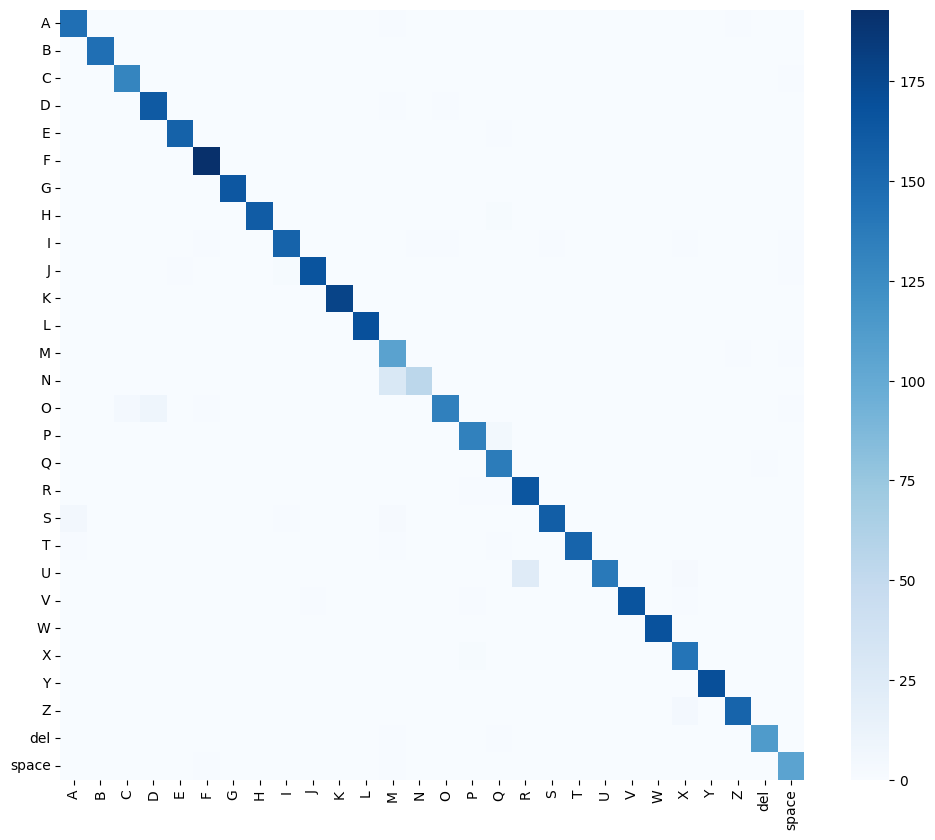

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test), axis=1)

print("--- CLASSIFICATION REPORT (F1-SCORE FOCUS) ---")
print(classification_report(y_test, y_pred, target_names=classes))

# Confusion Matrix
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=False, cmap='Blues')
plt.show()

In [ ]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('asl_landmark_model.tflite', 'wb') as f:
    f.write(tflite_model)

with open('labels.txt', 'w') as f:
    f.write('\n'.join(classes))

print("✅ Done! Download 'asl_landmark_model.tflite' and 'labels.txt'")

Saved artifact at '/tmp/tmphas7g80q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 63), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  135323107185616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107186384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107188304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107188688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107185040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107187920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107187728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107189072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107189456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107189648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135323107188496: Tenso